In [5]:
%pip install matplotlib seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [6]:
df = pd.read_csv('../data/vendas.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Order Date     9994 non-null   object 
 2   Ship Date      9994 non-null   object 
 3   Ship Mode      9994 non-null   object 
 4   Customer ID    9994 non-null   object 
 5   Customer Name  9994 non-null   object 
 6   Segment        9994 non-null   object 
 7   Country        9994 non-null   object 
 8   City           9994 non-null   object 
 9   State          9994 non-null   object 
 10  Postal Code    9994 non-null   int64  
 11  Region         9994 non-null   object 
 12  Product ID     9994 non-null   object 
 13  Category       9994 non-null   object 
 14  Sub-Category   9994 non-null   object 
 15  Product Name   9994 non-null   object 
 16  Sales          9994 non-null   float64
 17  Quantity       9994 non-null   int64  
 18  Discount

In [7]:
# 1. Convertendo a coluna 'Order Date' para o formato de data
# O parâmetro 'dayfirst=True' ajuda se as datas estiverem no formato brasileiro (DD/MM/YYYY).
# Se der erro, o pandas tenta adivinhar.
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')

# 2. Ordenando o DataFrame pela data (Forecasting exige ordem cronológica!)
df = df.sort_values('Order Date')

# 3. Verificando se mudou de 'object' para 'datetime'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 79 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     4066 non-null   datetime64[ns]
 2   Ship Date      9994 non-null   object        
 3   Ship Mode      9994 non-null   object        
 4   Customer ID    9994 non-null   object        
 5   Customer Name  9994 non-null   object        
 6   Segment        9994 non-null   object        
 7   Country        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   object        
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   object        
 14  Sub-Category   9994 non-null   object        
 15  Product Name   9994 non-n

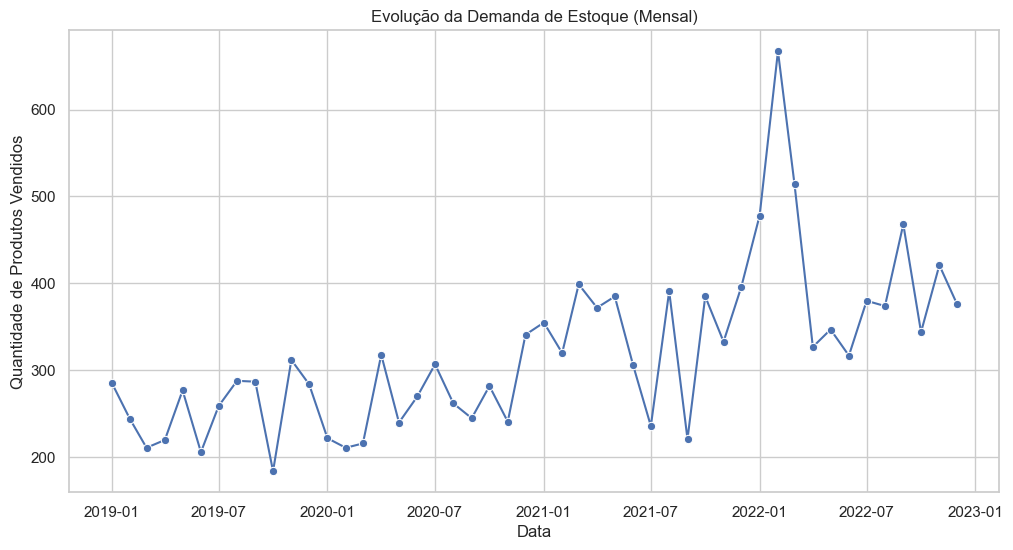

In [8]:
# 1. Definir a data como o índice (Index) do DataFrame

df = df.set_index('Order Date')

# 2. Reamostragem temporal

vendas_mensais = df['Quantity'].resample('MS').sum()

# 3. Visualizando a tendência ao longo do tempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=vendas_mensais, marker='o')
plt.title('Evolução da Demanda de Estoque (Mensal)')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.xlabel('Data')
plt.show()

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


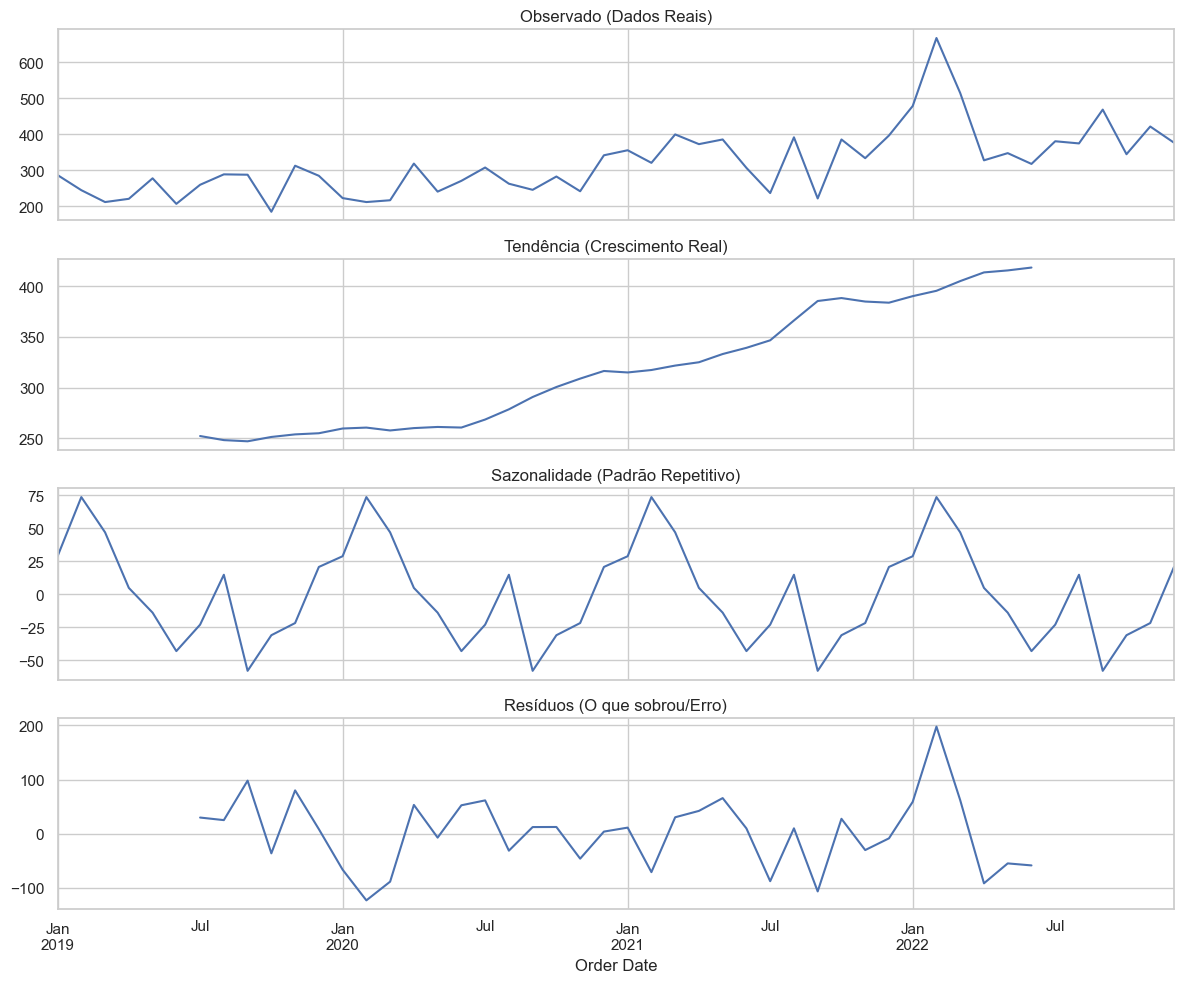

In [9]:
# Instalando a biblioteca de modelos estatísticos (se necessário)
%pip install statsmodels

from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicando a decomposição
# O modelo 'additive' assume que: Dado Real = Tendência + Sazonalidade + Erro
resultado = seasonal_decompose(vendas_mensais, model='additive')

# Plotando os 4 gráficos juntos
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

resultado.observed.plot(ax=ax1, title='Observado (Dados Reais)')
resultado.trend.plot(ax=ax2, title='Tendência (Crescimento Real)')
resultado.seasonal.plot(ax=ax3, title='Sazonalidade (Padrão Repetitivo)')
resultado.resid.plot(ax=ax4, title='Resíduos (O que sobrou/Erro)')

plt.tight_layout()
plt.show()

Meses para Treino: 36
Meses para Teste: 12


b:\ESTUDOS\Portfólio de Dados Git\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


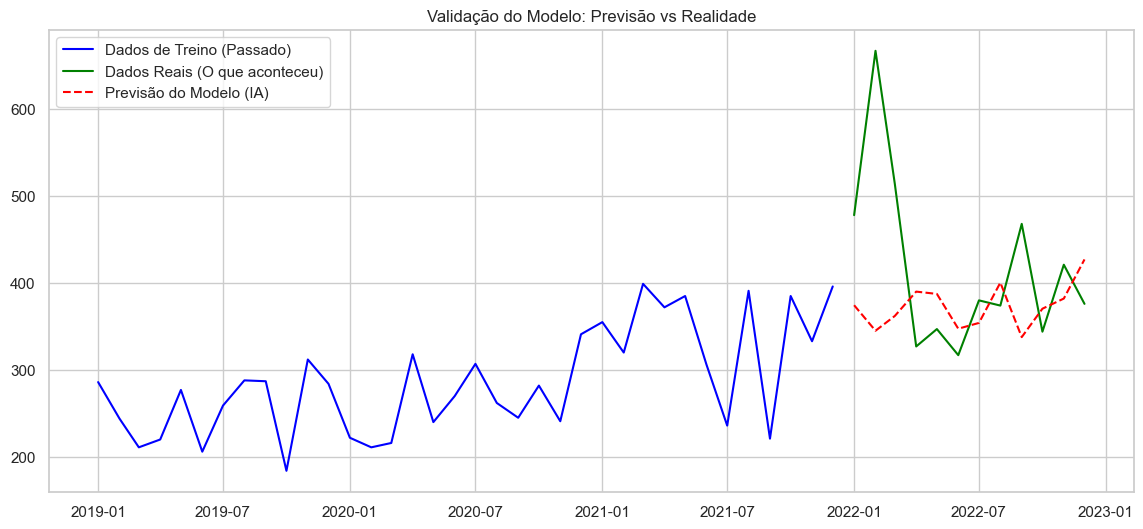

In [10]:
# separa os últimos 12 meses para testar se o modelo acerta
# O resto será usado para treinar a inteligência dele

tamanho_teste = 12
treino = vendas_mensais.iloc[:-tamanho_teste] # Do início até faltar 12 meses
teste = vendas_mensais.iloc[-tamanho_teste:]  # Os últimos 12 meses

print(f"Meses para Treino: {len(treino)}")
print(f"Meses para Teste: {len(teste)}")

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. Criando e Treinando o Modelo
# Usamos 'add' (aditivo) porque a amplitude da onda parece constante, não aumenta drasticamente com o tempo
modelo = ExponentialSmoothing(
    treino,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# 2. Fazendo a Previsão para os 12 meses que separamos
previsao = modelo.forecast(steps=12)

# 3. Visualizando a Magia
plt.figure(figsize=(14, 6))
plt.plot(treino.index, treino, label='Dados de Treino (Passado)', color='blue')
plt.plot(teste.index, teste, label='Dados Reais (O que aconteceu)', color='green')
plt.plot(teste.index, previsao, label='Previsão do Modelo (IA)', color='red', linestyle='--')

plt.legend()
plt.title('Validação do Modelo: Previsão vs Realidade')
plt.show()